In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gdown

## Helper functions

In [2]:
def fetch_dataset(key, dataset_name):
    cmd = !gdown --fuzzy {key} -O {dataset_name}
    path = pd.Series(cmd).str.extractall(r'(To.*)').reset_index()[0].iloc[0].split(': ')[1]
    print(f'{dataset_name} path: {path}')
    return path

def get_null_percentage(df):
    null_series = ((df.isnull().sum()/len(df))*100).sort_values()
    return null_series

def generate_time_features(df):
    df = df.reset_index()
    df.loc[:,'day']  = df['Order Date'].dt.day
    df.loc[:,'month']  = df['Order Date'].dt.month
    df.loc[:,'year']  = df['Order Date'].dt.year
    df.loc[:,'is_weekend']  = df['Order Date'].dt.weekday > 5
    df.loc[:,'day_of_week']  = df['Order Date'].dt.day_of_week
    df.loc[:,'day_of_year']  = df['Order Date'].dt.day_of_year
    df.loc[:,'quarter']  = df['Order Date'].dt.quarter
    df.loc[:,'is_month_start']  = df['Order Date'].dt.is_month_start
    df.loc[:,'is_month_end']  = df['Order Date'].dt.is_month_end
    df.loc[:,'is_year_start']  = df['Order Date'].dt.is_year_start
    df.loc[:,'is_year_end']  = df['Order Date'].dt.is_year_end
    df = df.set_index('Order Date')
    return df

def add_holidays_past_2021(df):

    _2022 = pd.Series(['2022-12-26', '2022-11-24', '2022-11-11', '2022-10-10', '2022-09-05', '2022-07-04', '2022-06-20', '2022-05-30', '2022-02-21', '2022-01-21', '2023-01-02', '2023-01-16', '2023-02-20']) 
    
    _2022 = pd.to_datetime(_2022)
    dates = pd.Series(['January 02 2023',
    'January 16 2023',
    'February 20 2023',
    'May 29 2023',
    'June 19 2023',
    'July 04 2023',
    'September 04 2023',
    'October 09 2023',
    'November 10 2023',
    'November 23 2023',
    'December 25 2023',
    'January 01 2024',
    'January 15 2024',
    'February 19 2024',
    'May 27 2024',
    'June 19 2024',
    'July 04 2024',
    'September 02 2024',	
    'October 14 2024',
    'November 11 2024',	
    'November 28 2024',	
    'December 25 2024',
    'January 01 2025',
    'January 20 2025',
    'January 20 2025',
    'February 17 2025',
    'May 26 2025',
    'June 19 2025',
    'July 04 2025',
    'September 01 2025',	
    'October 13 2025',
    'November 11 2025',
    'November 27 2025',
    'December 25 2025',
    'January 01 2026',
    'January 19 2026',
    'February 16 2026',
    'May 25 2026',
    'June 19 2026',
    'July 03 2026',
    'September 07 2025',
    'October 12 2026',
    'November 11 2026',
    'November 26 2026',
    'December 25 2026'
                      ])
    fedral_holidays_2023_plus = pd.to_datetime(dates)
    fedral_holdidays_22_plus = pd.concat([_2022, fedral_holidays_2023_plus], axis=0).sort_values()
    fedral_holdidays_22_plus = pd.Series(fedral_holdidays_22_plus.unique())
    fedral_holdidays_22_plus.index = range(len(fedral_holdidays_22_plus))
    fedral_holdidays_22_plus = pd.DataFrame(fedral_holdidays_22_plus).rename(columns={0:'date'})
    fedral_holdidays_22_plus['fedral_holiday'] = True
    fedral_holdidays_22_plus = fedral_holdidays_22_plus.set_index('date')
    return pd.merge(df, fedral_holdidays_22_plus, how='left', left_index = True, right_index=True)

## Purchases Dataset

In [3]:
path = fetch_dataset("1HdJj68eO9NTZlpwZcLYqdtPqrbKs1cxj", "amazon_purchases.csv")

amazon_purchases.csv path: C:\Users\rohit\5010\project\AmazonSalesPredictor\amazon_purchases.csv


In [4]:
purchases = pd.read_csv(path)

In [5]:
purchases.rename(columns={'ASIN/ISBN (Product Code)': 'product_code'}, inplace=True)

In [6]:
purchases['Order Date'] = pd.to_datetime(purchases['Order Date'])

In [7]:
purchases.sort_values(by='Order Date', inplace=True)

In [8]:
purchases= purchases[purchases['Order Date'].dt.year<2023]

In [9]:
purchases

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,product_code,Category,Survey ResponseID
1067944,2018-01-01,29.99,1.0,GA,LEGO Super Heroes DC Wonder Woman Warrior Batt...,B072HT813T,TOYS_AND_GAMES,R_3HzRfw5sNEvrFRf
977510,2018-01-01,11.99,1.0,NaN,"OLIKEME Women's Shapewear,Adjustable High Wais...",B074TY774J,UNDERGARMENT_THIGH_SLIMMER,R_32VcKmw1biSyknq
977511,2018-01-01,9.45,1.0,NaN,How to Traumatize Your Children: 7 Proven Meth...,1601063091,BLANK_BOOK,R_32VcKmw1biSyknq
977512,2018-01-01,13.42,1.0,NaN,Sh*t My Kids Ruined: An A-Z Celebration of Kid...,034552716X,ABIS_BOOK,R_32VcKmw1biSyknq
977513,2018-01-01,6.99,1.0,TX,Ohyeah Women's Mesh T Back Artificial Pearls S...,B014K342XS,UNDERPANTS,R_32VcKmw1biSyknq
...,...,...,...,...,...,...,...,...
836153,2022-12-31,29.96,1.0,CA,Lezonic Rechargeable LED Flameless Pillar Cand...,B08Y6LVPW5,LAMP,R_2r7Zl5CTeW1dMqd
883628,2022-12-31,23.40,1.0,AZ,"Spotted Zebra Girls and Toddlers' Leggings, Mu...",B07979NP2M,PANTS,R_2vYO5d3Ry8qjf5g
883627,2022-12-31,28.50,1.0,AZ,Spotted Zebra Girls and Toddlers' Long-Sleeve ...,B07GQCQBJ2,SHIRT,R_2vYO5d3Ry8qjf5g
203927,2022-12-31,11.78,1.0,NC,Fisher Snack Oven Roasted Never Fried Whole Ca...,B089LJLC3S,NUT_AND_SEED,R_1Oov0G05pkQnKNn


In [10]:
purchases['total_sales'] = purchases['Quantity'] * purchases['Purchase Price Per Unit']

# EDA

In [11]:
years_of_interest = ['2018-01-01', '2018-12-31', '2019-01-01', '2019-12-31', '2020-01-01', '2020-12-31', '2021-01-01', '2021-12-31', '2022-01-01', '2022-12-31']

In [12]:
purchases_clipped =  purchases[purchases['Order Date'].isin([pd.to_datetime(year) for year in years_of_interest])]

In [13]:
purchases_clipped['Order Date'].value_counts().sort_index()

Order Date
2018-01-01     639
2018-12-31     513
2019-01-01     621
2019-12-31     692
2020-01-01     829
2020-12-31    1277
2021-01-01    1319
2021-12-31    1026
2022-01-01    1135
2022-12-31     595
Name: count, dtype: int64

Text(0.5, 1.0, 'States with the most mean')

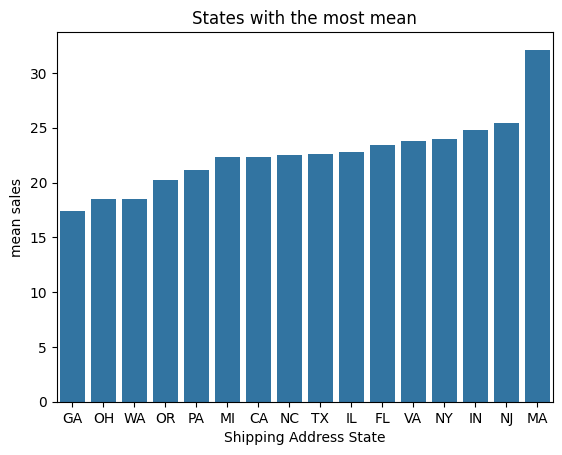

In [21]:
sns.barplot(purchases_clipped.groupby('Shipping Address State')['total_sales'].mean().loc[['MA', 'MI', 'IN', 'PA', 'TX', 'OH', 'NJ', 'WA', 'VA', 'NY', 'OR', 'NC',
       'CA', 'IL', 'GA', 'FL']].sort_values())
plt.ylabel('mean sales')
plt.title('States with the most mean')

Text(0.5, 1.0, 'States with the most standard deviation')

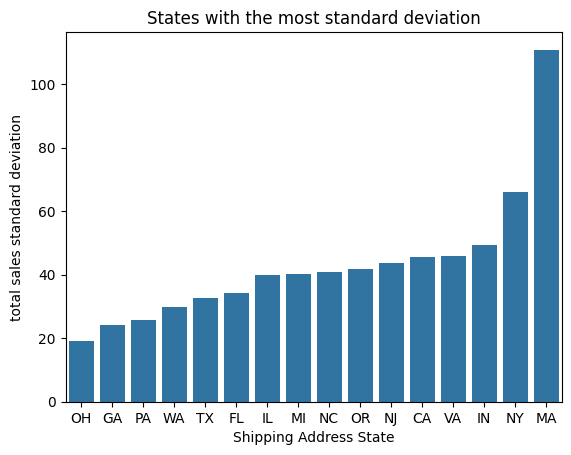

In [22]:
sns.barplot(purchases_clipped.groupby('Shipping Address State')['total_sales'].std().loc[['MA', 'MI', 'IN', 'PA', 'TX', 'OH', 'NJ', 'WA', 'VA', 'NY', 'OR', 'NC',
       'CA', 'IL', 'GA', 'FL']].sort_values())
plt.ylabel('total sales standard deviation')
plt.title('States with the most standard deviation')

Text(0, 0.5, 'total sales')

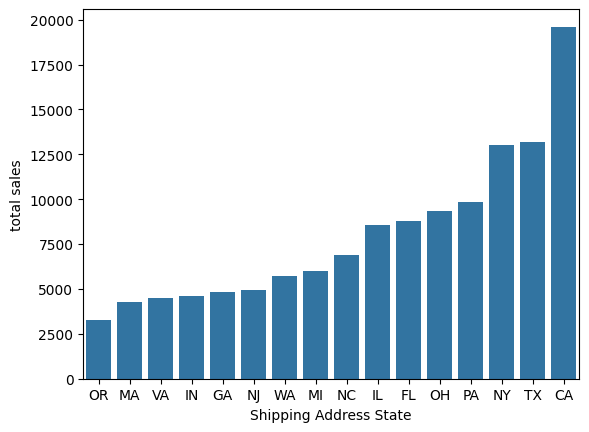

In [16]:
sns.barplot(purchases_clipped.groupby('Shipping Address State')['total_sales'].sum().loc[['MA', 'MI', 'IN', 'PA', 'TX', 'OH', 'NJ', 'WA', 'VA', 'NY', 'OR', 'NC',
       'CA', 'IL', 'GA', 'FL']].sort_values())
plt.ylabel('total sales')


In [17]:
states_frequencies = purchases.groupby(['Order Date', 'Shipping Address State'])['total_sales'].sum().reset_index()['Shipping Address State'].value_counts().sort_values()

In [18]:
states_frequencies.index

Index(['PR', 'WY', 'ND', 'AK', 'SD', 'MT', 'VT', 'RI', 'HI', 'ID', 'ME', 'DE',
       'NM', 'DC', 'WV', 'IA', 'NH', 'MS', 'UT', 'KS', 'OK', 'AR', 'NE', 'CT',
       'NV', 'SC', 'AL', 'MO', 'LA', 'AZ', 'CO', 'MD', 'TN', 'MN', 'KY', 'WI',
       'MA', 'MI', 'IN', 'PA', 'TX', 'OH', 'NJ', 'WA', 'VA', 'NY', 'OR', 'NC',
       'CA', 'IL', 'GA', 'FL'],
      dtype='object', name='Shipping Address State')

Text(0.5, 1.0, 'States by frequency')

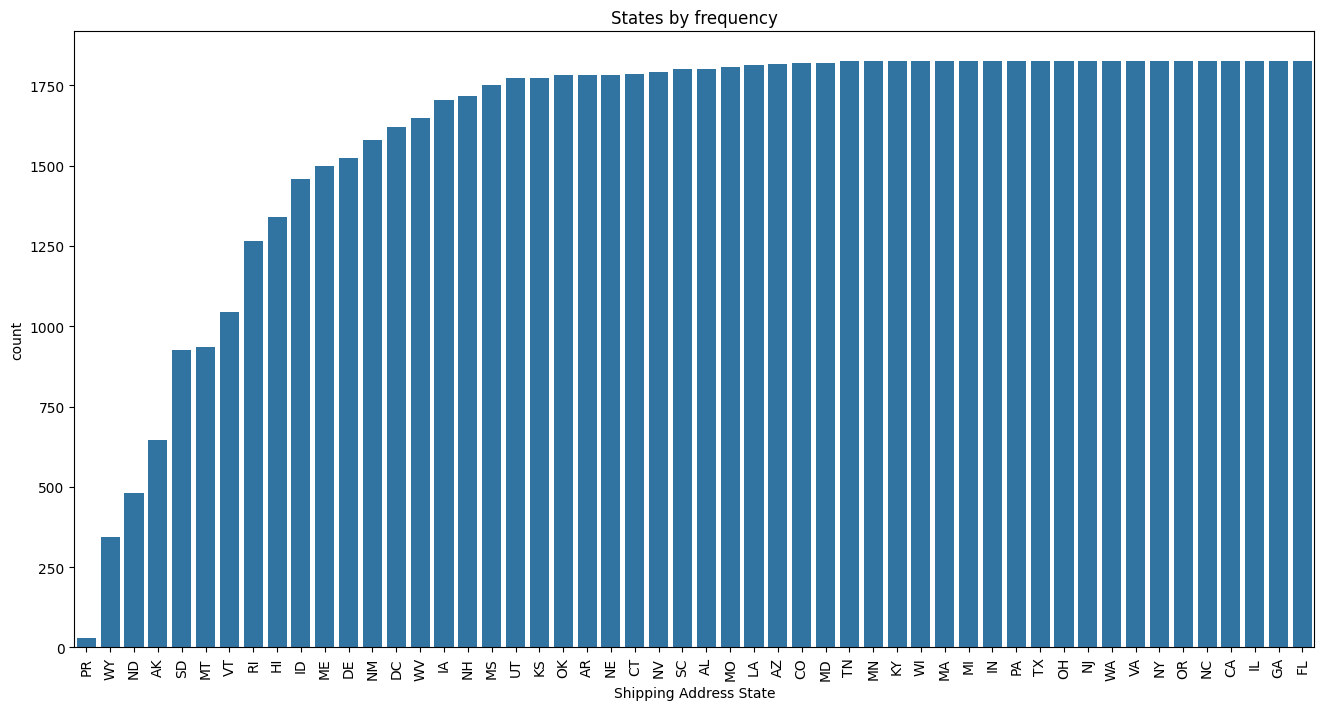

In [23]:
plt.figure(dpi=100, figsize=(16,8))
sns.barplot(x = states_frequencies.index, y =states_frequencies )
plt.xticks(rotation=90);
plt.title('States by frequency')

<Axes: xlabel='Order Date'>

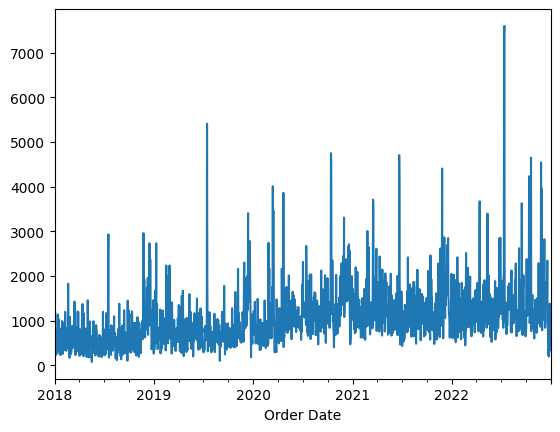

In [20]:
purchases[purchases['Shipping Address State'] == 'OH'].groupby('Order Date')['total_sales'].sum().plot()

<Axes: xlabel='Order Date'>

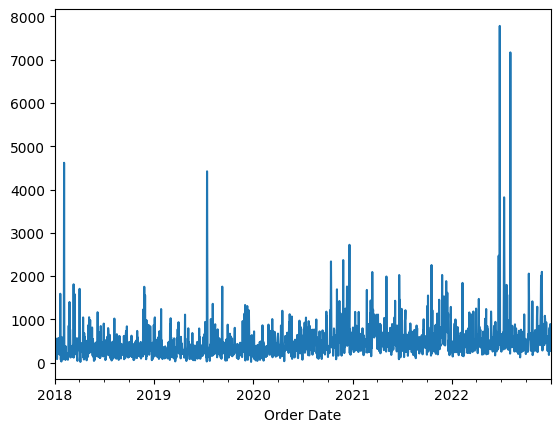

In [21]:
purchases[purchases['Shipping Address State'] == 'OR'].groupby('Order Date')['total_sales'].sum().plot()

Text(0.5, 1.0, 'Total sales in GA')

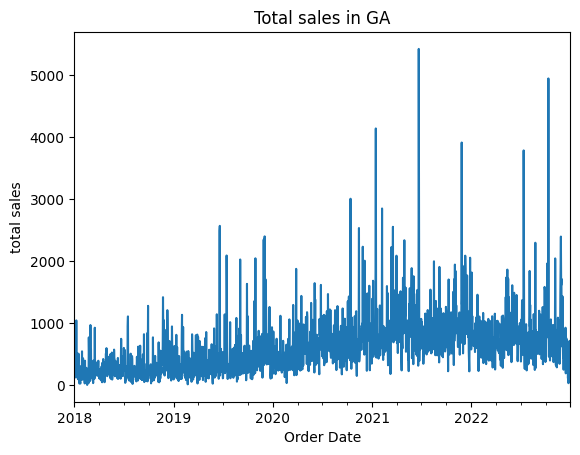

In [45]:
purchases[purchases['Shipping Address State'] == 'GA'].groupby('Order Date')['total_sales'].sum().plot()
plt.ylabel('total sales')
plt.title('Total sales in GA')

Text(0.5, 1.0, 'Total sales in CA')

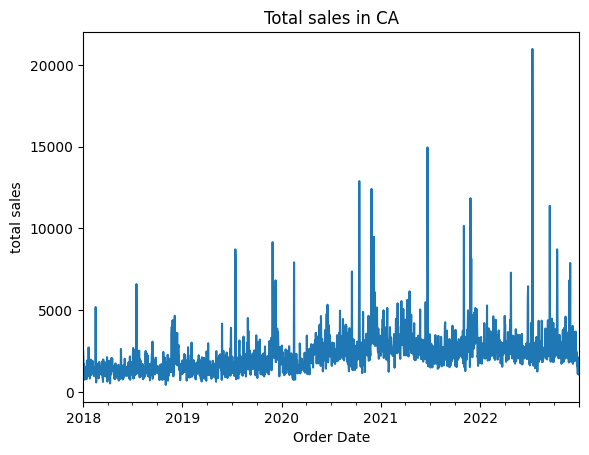

In [27]:
purchases[purchases['Shipping Address State'] == 'CA'].groupby('Order Date')['total_sales'].sum().plot()
plt.ylabel('total sales')
plt.title('Total sales in CA')

CA best performer
GA least performer

## Categories Dataset

In [28]:
path = fetch_dataset("19167R4OV0GWNiCHTh3w9T07616S91enj", "amazon_categories.csv")

amazon_categories.csv path: C:\Users\rohit\5010\project\AmazonSalesPredictor\amazon_categories.csv


In [29]:
categories = pd.read_csv(path)

In [30]:
categories

,id,category_name
0,1,Beading & Jewelry Making
1,2,Fabric Decorating
2,3,Knitting & Crochet Supplies
3,4,Printmaking Supplies
4,5,Scrapbooking & Stamping Supplies
...,...,...
243,262,"Xbox Series X & S Consoles, Games & Accessories"
244,263,PC Games & Accessories
245,264,Baby Girls' Clothing & Shoes
246,265,Boys' School Uniforms


# Products Dataset

In [31]:
path = fetch_dataset("1yoaKl-7wctxH315gH_M15fS5WERnFlHe", "amazon_products.csv")

amazon_products.csv path: C:\Users\rohit\5010\project\AmazonSalesPredictor\amazon_products.csv


In [32]:
products = pd.read_csv(path)
products = products.rename(columns={'asin':'product_code'})

In [33]:
products = pd.merge(products, categories, how='inner', left_on='category_id', right_on='id').drop('id', axis=1)

In [34]:
products

,product_code,title,imgUrl,productURL,stars,reviews,price,listPrice,category_id,isBestSeller,boughtInLastMonth,category_name
0,B014TMV5YE,"Sion Softside Expandable Roller Luggage, Black...",https://m.media-amazon.com/images/I/815dLQKYIY...,https://www.amazon.com/dp/B014TMV5YE,4.5,0,139.99,0.00,104,False,2000,Suitcases
1,B07GDLCQXV,Luggage Sets Expandable PC+ABS Durable Suitcas...,https://m.media-amazon.com/images/I/81bQlm7vf6...,https://www.amazon.com/dp/B07GDLCQXV,4.5,0,169.99,209.99,104,False,1000,Suitcases
2,B07XSCCZYG,Platinum Elite Softside Expandable Checked Lug...,https://m.media-amazon.com/images/I/71EA35zvJB...,https://www.amazon.com/dp/B07XSCCZYG,4.6,0,365.49,429.99,104,False,300,Suitcases
3,B08MVFKGJM,Freeform Hardside Expandable with Double Spinn...,https://m.media-amazon.com/images/I/91k6NYLQyI...,https://www.amazon.com/dp/B08MVFKGJM,4.6,0,291.59,354.37,104,False,400,Suitcases
4,B01DJLKZBA,Winfield 2 Hardside Expandable Luggage with Sp...,https://m.media-amazon.com/images/I/61NJoaZcP9...,https://www.amazon.com/dp/B01DJLKZBA,4.5,0,174.99,309.99,104,False,400,Suitcases
...,...,...,...,...,...,...,...,...,...,...,...,...
1426332,B00R3LIKCO,American Flag Patriotic USA Classic 5 Panel Me...,https://m.media-amazon.com/images/I/71PDJFz6AA...,https://www.amazon.com/dp/B00R3LIKCO,4.2,0,14.95,0.00,112,False,0,Men's Accessories
1426333,B098BQ7ZQ3,Men's Baseball Cap - H2O-DRI Line Up Curved Br...,https://m.media-amazon.com/images/I/812Tycexs4...,https://www.amazon.com/dp/B098BQ7ZQ3,4.4,0,33.99,0.00,112,False,0,Men's Accessories
1426334,B07X1MVNT1,[4 Pack] Adjustable Eyeglasses and Sunglasses ...,https://m.media-amazon.com/images/I/61vvYW1S9J...,https://www.amazon.com/dp/B07X1MVNT1,3.6,0,8.54,0.00,112,False,0,Men's Accessories
1426335,B08XLBG8V9,Ax2002 Aviator Sunglasses,https://m.media-amazon.com/images/I/51+yjD4F1x...,https://www.amazon.com/dp/B08XLBG8V9,4.5,0,54.36,57.39,112,False,0,Men's Accessories


In [35]:
purchases[purchases['product_code'] == 'B07TF72BMC']

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,product_code,Category,Survey ResponseID,total_sales
1524776,2022-08-06,21.98,3.0,NC,MAGCOMSEN Men's Polo Shirt Quick Dry Performan...,B07TF72BMC,NaN,R_OiYmnNVvK5ABUK5,65.94


In [36]:
product_codes_category_null = purchases[purchases['Category'].isnull()]['product_code']

data_replacements = products[products['product_code'].isin(product_codes_category_null.unique())][['product_code','title','category_name']]

purchases = pd.merge(purchases, data_replacements, on='product_code', how='left')

purchases.loc[(purchases['Category'].isnull())&(purchases['category_name'].notnull()), 'Category'] = purchases.loc[(purchases['Category'].isnull())&(purchases['category_name'].notnull()), 'category_name']

purchases.loc[(purchases['Title'].isnull()) & (purchases['title'].notnull()), 'Title'] = purchases.loc[(purchases['Title'].isnull()) & (purchases['title'].notnull()), 'title']

In [37]:
purchases[purchases['product_code'] == 'B07TF72BMC']

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,product_code,Category,Survey ResponseID,total_sales,title,category_name
1632833,2022-08-06,21.98,3.0,NC,MAGCOMSEN Men's Polo Shirt Quick Dry Performan...,B07TF72BMC,Men's Clothing,R_OiYmnNVvK5ABUK5,65.94,Men's Polo Shirt Quick Dry Performance Short S...,Men's Clothing


In [38]:
purchases.drop(['title', 'category_name'], axis=1, inplace=True)

In [39]:
get_null_percentage(purchases)

Order Date                 0.000000
Purchase Price Per Unit    0.000000
Quantity                   0.000000
Survey ResponseID          0.000000
total_sales                0.000000
product_code               0.053181
Shipping Address State     4.740133
Category                   4.856878
Title                      4.875046
dtype: float64

In [40]:
purchases[purchases['Shipping Address State'].isnull() & purchases['Category'].isnull()]

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,product_code,Category,Survey ResponseID,total_sales
23,2018-01-01,6.50,1.0,NaN,NaN,B00IDZZ96Y,NaN,R_32VcKmw1biSyknq,6.50
218,2018-01-01,14.99,1.0,NaN,NaN,B073PK9K12,NaN,R_3HNOpheZEt8babI,14.99
304,2018-01-01,99.99,1.0,NaN,NaN,B074SXDRC3,NaN,R_25u6PwLCFpZwuzY,99.99
1366,2018-01-03,44.99,1.0,NaN,NaN,B075R9KYM7,NaN,R_T7v2MVF1Q9nTL2N,44.99
1992,2018-01-04,18.93,1.0,NaN,NaN,B017DX9CRI,NaN,R_1ONrCkUEhKm1LZY,18.93
...,...,...,...,...,...,...,...,...,...
1803513,2022-12-21,50.00,1.0,NaN,NaN,B0BHRC27H1,NaN,R_3j7P0eEOFqWjGrT,50.00
1803970,2022-12-22,20.00,1.0,NaN,NaN,B0BHR6VFCB,NaN,R_24csoaO569P4Yzz,20.00
1804034,2022-12-22,15.00,1.0,NaN,NaN,B0BHRB7GZV,NaN,R_1JJ8YCoLzDqN39u,15.00
1805116,2022-12-24,13.57,1.0,NaN,NaN,B0BHTLHT96,NaN,R_3JnjKsPAuFGDhrx,13.57


In [41]:
get_null_percentage(purchases.dropna(axis=0,subset= ['Shipping Address State','Category']))

Order Date                 0.000000
Purchase Price Per Unit    0.000000
Quantity                   0.000000
Shipping Address State     0.000000
Survey ResponseID          0.000000
Category                   0.000000
total_sales                0.000000
product_code               0.017080
Title                      0.032147
dtype: float64

In [42]:
purchases.dropna(axis=0,subset= ['Shipping Address State','Category'], inplace=True)

In [43]:
purchases

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,product_code,Category,Survey ResponseID,total_sales
0,2018-01-01,29.99,1.0,GA,LEGO Super Heroes DC Wonder Woman Warrior Batt...,B072HT813T,TOYS_AND_GAMES,R_3HzRfw5sNEvrFRf,29.99
4,2018-01-01,6.99,1.0,TX,Ohyeah Women's Mesh T Back Artificial Pearls S...,B014K342XS,UNDERPANTS,R_32VcKmw1biSyknq,6.99
5,2018-01-01,21.90,2.0,UT,STRATTON MEN’S ADJUSTABLE SPLIT TOE CEDAR SHOE...,B01J0AHEDQ,SHOE_TREE,R_1DULPnUes4caEHg,43.80
6,2018-01-01,13.99,1.0,NY,BALI SECRETS All Natural Deodorant for Women &...,B012E9DMNQ,BODY_DEODORANT,R_333cPUAJRgYXqi1,13.99
7,2018-01-01,8.59,1.0,MN,G4Free 15L Drawstring Backpack 15L&20L Cinch B...,B01EHIOHZ4,BACKPACK,R_2S0u8lcDVOW3xTU,8.59
...,...,...,...,...,...,...,...,...,...
1810788,2022-12-31,29.96,1.0,CA,Lezonic Rechargeable LED Flameless Pillar Cand...,B08Y6LVPW5,LAMP,R_2r7Zl5CTeW1dMqd,29.96
1810789,2022-12-31,23.40,1.0,AZ,"Spotted Zebra Girls and Toddlers' Leggings, Mu...",B07979NP2M,PANTS,R_2vYO5d3Ry8qjf5g,23.40
1810790,2022-12-31,28.50,1.0,AZ,Spotted Zebra Girls and Toddlers' Long-Sleeve ...,B07GQCQBJ2,SHIRT,R_2vYO5d3Ry8qjf5g,28.50
1810791,2022-12-31,11.78,1.0,NC,Fisher Snack Oven Roasted Never Fried Whole Ca...,B089LJLC3S,NUT_AND_SEED,R_1Oov0G05pkQnKNn,11.78


# EDA

In [46]:
category_frequencies = purchases.groupby(['Order Date', 'Category'])['total_sales'].sum().reset_index()['Category'].value_counts().sort_values()

In [47]:
category_frequencies

Category
AGRICULTURAL_SUPPLIES        1
THERMISTOR                   1
POWER_RACK                   1
LAB_UTENSIL                  1
VIDEO_DEVICE                 1
                          ... 
PET_FOOD                  1825
ELECTRONIC_CABLE          1825
HEALTH_PERSONAL_CARE      1825
NUTRITIONAL_SUPPLEMENT    1826
ABIS_BOOK                 1826
Name: count, Length: 1981, dtype: int64

In [49]:
category = []
for i in range(max(category_frequencies)):
    indices = category_frequencies[category_frequencies==i].index
    for index in indices:
        if len(purchases[purchases['Category'] == index].groupby(purchases['Order Date'].dt.year)['Category'].count()) == 5:
            category.append(index)

In [43]:
category

'BEER'

In [44]:
category_frequencies[category_frequencies.index=='BEER']

Category
BEER    220
Name: count, dtype: int64

In [45]:
purchases[purchases['Category'] == 'BEER'].groupby(purchases['Order Date'].dt.year)['Category'].count()

Order Date
2019      2
2020    108
2021    106
2022    137
Name: Category, dtype: int64

In [46]:
purchases[purchases['Category'] == 'HEADPHONES']

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,product_code,Category,Survey ResponseID,total_sales
275,2018-01-01,99.99,1.0,TX,SteelSeries Arctis 7 Lag-Free Wireless Gaming ...,B01LYNEIEI,HEADPHONES,R_O9FzIlCvCxllJSN,99.99
366,2018-01-01,29.99,1.0,UT,Turtle Beach - Ear Force Disney Infinity: Marv...,B00KVQQJBW,HEADPHONES,R_5oK9SmlCA2Td9rb,29.99
393,2018-01-01,21.95,1.0,PA,M-Audio SP-2 - Universal Sustain Pedal with Pi...,B00063678K,HEADPHONES,R_2aV7W397pASsmOo,21.95
438,2018-01-01,8.01,1.0,CA,"Panasonic ErgoFit Wired Earbuds, In-Ear Headph...",B003EM8008,HEADPHONES,R_UlOQHrMf1EiWKQx,8.01
461,2018-01-01,9.99,1.0,TN,Senzer H1 Bass In Ear Headphones Noise Isolati...,B07198ZPJ5,HEADPHONES,R_tR7F4DbwZExTCSZ,9.99
...,...,...,...,...,...,...,...,...,...
1809520,2022-12-29,9.49,1.0,OH,abcGoodefg 1 Pin 2.5mm Walkie Talkie Earpiece ...,B00QI7I5BA,HEADPHONES,R_1K0zy1Mt6OG2jGF,9.49
1809706,2022-12-30,39.95,1.0,FL,SmithOutlet 10 Pack Over The Head Low Cost Hea...,B01JWYBNIW,HEADPHONES,R_3D1OqGz1QgTobzj,39.95
1809973,2022-12-30,35.99,1.0,MA,"EarFun® Free 2S Wireless Earbuds, [Upgraded Ve...",B092M34HQ3,HEADPHONES,R_2tfEDXuyNRcQoWs,35.99
1810035,2022-12-30,5.97,1.0,CA,"Earbuds for Kindle Fire, Earphone for Kindle e...",B0BG11RN5F,HEADPHONES,R_1EbBdl7Uln82HNr,5.97


# Customers Dataset

In [47]:
path = fetch_dataset("1x737vYSZplHtZdxo99pqB1TGXhcoA6iE", "survey.csv")

survey.csv path: C:\Users\rohit\5010\project\AmazonSalesPredictor\survey.csv


In [48]:
customers = pd.read_csv(path)
customers

,Survey ResponseID,Q-demos-age,Q-demos-hispanic,Q-demos-race,Q-demos-education,Q-demos-income,Q-demos-gender,Q-sexual-orientation,Q-demos-state,Q-amazon-use-howmany,...,Q-substance-use-marijuana,Q-substance-use-alcohol,Q-personal-diabetes,Q-personal-wheelchair,Q-life-changes,Q-sell-YOUR-data,Q-sell-consumer-data,Q-small-biz-use,Q-census-use,Q-research-society
0,R_1ou69fj4DQGsVcp,35 - 44 years,No,Black or African American,High school diploma or GED,"$25,000 - $49,999",Female,heterosexual (straight),Iowa,2,...,No,Yes,No,No,Lost a job,No,No,No,No,No
1,R_2UbJL30HRjK1sdD,45 - 54 years,No,White or Caucasian,High school diploma or GED,"$100,000 - $149,999",Male,heterosexual (straight),Ohio,2,...,No,No,No,No,NaN,No,No,No,No,Yes
2,R_UPXamGKtmf4RVIZ,25 - 34 years,No,White or Caucasian,High school diploma or GED,"$25,000 - $49,999",Male,heterosexual (straight),Arkansas,1 (just me!),...,No,No,Yes,No,NaN,No,No,No,No,Yes
3,R_2dYk5auG9Fv5Qve,35 - 44 years,Yes,White or Caucasian,"Graduate or professional degree (MA, MS, MBA, ...","$50,000 - $74,999",Male,heterosexual (straight),Tennessee,1 (just me!),...,No,No,No,No,NaN,No,No,No,No,No
4,R_2aP0GyIR66gSTiR,25 - 34 years,No,White or Caucasian,High school diploma or GED,"$50,000 - $74,999",Male,heterosexual (straight),Virginia,2,...,No,Yes,No,No,NaN,No,Yes if consumers get part of the profit,I don't know,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5022,R_1JLBP1fFf3p8tpy,25 - 34 years,No,White or Caucasian,Bachelor's degree,"$50,000 - $74,999",Male,heterosexual (straight),North Carolina,2,...,Yes,Yes,No,No,NaN,No,No,No,No,Yes
5023,R_Odixb15Ykmxb0Dn,65 and older,No,White or Caucasian,"Graduate or professional degree (MA, MS, MBA, ...","$100,000 - $149,999",Female,heterosexual (straight),Michigan,1 (just me!),...,No,No,No,No,NaN,No,No,No,No,Yes
5024,R_2uKaOXO8LfgoFf3,35 - 44 years,No,Black or African American,High school diploma or GED,"Less than $25,000",Male,LGBTQ+,Georgia,1 (just me!),...,No,No,No,No,NaN,No,No,I don't know,No,No
5025,R_2ZZSS68rfn9BMtt,45 - 54 years,No,White or Caucasian,Bachelor's degree,"Less than $25,000",Male,LGBTQ+,Arizona,1 (just me!),...,No,Yes,No,No,NaN,Yes if I get part of the profit,Yes if consumers get part of the profit,Yes,Yes,Yes


# EDA

In [49]:
customer_behavior = customers.groupby('Survey ResponseID').agg({     
    'Total Spending': ['mean','sum'],           
    'ASIN/ISBN': 'count'
}).reset_index()

customer_behavior

KeyError: "Column(s) ['ASIN/ISBN', 'Total Spending'] do not exist"

# Holidays Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("donnetew/us-holiday-dates-2004-2021")

print("Path to dataset files:", path)

In [ ]:
holidays = pd.read_csv(os.path.join(path,'US Holiday Dates (2004-2021).csv'))

In [ ]:
holidays['is_holiday'] = True
holidays['Date'] = pd.to_datetime(holidays['Date'])

In [ ]:
holidays

# EDA

## Inflation Dataset

In [ ]:
path = fetch_dataset("1uuTBlEA2caOIyv4-R_G2OlekBCw-i_Le", "inflation.csv")
inflation_df = pd.read_csv(path)
inflation_df['observation_date'] = pd.to_datetime(inflation_df['observation_date'])
inflation_df = inflation_df.rename(columns={'T10YIEM':'inflation_rate'}).set_index('observation_date')

In [ ]:
inflation_df

## EDA

In [ ]:
inflation_df.plot()
plt.ylabel('inflation rate')